In [1]:
from keratin.metrics import dice, dice_loss
import numpy as np
from keratin.networks import unet
from keras.optimizers import Adam
from skimage.transform import resize
import keras
%pylab inline

Using TensorFlow backend.
Failed to import duecredit due to No module named 'duecredit'


Populating the interactive namespace from numpy and matplotlib


/Users/akeshavan/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['resize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
model = unet(256,256,n_channels=2)

/Users/akeshavan/Dropbox/software/keratin/keratin/networks.py:89: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  return km.Model(input=inputs, outputs=outputs)


In [3]:
model.compile(optimizer=Adam(lr=10e-5), 
              loss=dice_loss, 
              metrics=[dice])

In [4]:
from glob import glob

In [5]:
images = sorted(glob("/Users/akeshavan/Dropbox/data/meningioma/tiles/*/base*.jpg"))
hints = sorted(glob("/Users/akeshavan/Dropbox/data/meningioma/tiles/*/agg*.jpg"))

def make256(images, hints = None):
    
    if hints:
        bigM = np.zeros((len(images), 256, 256, 1))
    else:
        bigM = np.zeros((len(images), 256, 256, 2))
    
    for i, im in enumerate(images):

        data = imread(im)
        if len(data.shape) == 3:
            do_mean = True
            data = (data[:,:,0]/255).astype(np.float32)
            if hints:
                hint = imread(hints[i]).astype(np.float32)
            
        else:
            do_mean = False
            data = (data/np.max(data)).astype(np.float32)

        if data.shape[0] > 256:
            data = data[:256, :]
        if data.shape[1] > 256:
            data = data[:, :256]

        data_pad = np.pad(data, (((256-data.shape[0])//2, ((256-data.shape[0]) + (data.shape[0]%2 >0))//2), 
                                 ((256-data.shape[1])//2, ((256-data.shape[1]) + (data.shape[1]%2 >0))//2)), 
                          "constant", constant_values = (0,0))
        
        if hints:
            hint_pad = np.pad(hint, (((256-hint.shape[0])//2, ((256-hint.shape[0]) + (hint.shape[0]%2 >0))//2), 
                         ((256-hint.shape[1])//2, ((256-hint.shape[1]) + (hint.shape[1]%2 >0))//2)), 
                  "constant", constant_values = (0,0))

        
        if do_mean:
            bigM[i,:,:,0] = (data_pad - np.mean(data_pad)) / np.std(data_pad)
            if hints:
                bigM[i,:,:,1] = (hint_pad - np.mean(hint_pad)) / np.std(hint_pad)
            
            #bigM_mean = np.mean(bigM)
            #bigM_std = np.std(bigM)
            #bigM = (bigM - bigM_mean)/bigM_std
        
    return bigM

In [6]:
bigM_base = make256(images, hints)

In [7]:
masks = glob("/Users/akeshavan/Dropbox/data/meningioma/tiles/s*/truth*.png")
bigM_mask = make256(masks)

In [8]:
idx = list(range(188))
np.random.shuffle(idx)

In [9]:
train = idx[:int(0.8*bigM_base.shape[0])]
test = idx[int(0.8*bigM_base.shape[0]):int(0.9*bigM_base.shape[0])]
val = idx[int(0.9*bigM_base.shape[0]):]

In [10]:
x_train = bigM_base[train, :]
y_train = bigM_mask[train, :]

x_test = bigM_base[test, :]
y_test = bigM_mask[test, :]

x_val = bigM_base[val, :]
y_val = bigM_mask[val, :]


In [11]:
x_train.shape

(150, 256, 256, 2)

In [12]:
model.fit(x_train, y_train, batch_size=4, 
          epochs=12, verbose=1, validation_data=(x_val, y_val), 
          callbacks= [keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, 
                                                 batch_size=32, write_graph=True, 
                                                 write_grads=False, write_images=False, 
                                                 embeddings_freq=0, embeddings_layer_names=None, 
                                                 embeddings_metadata=None)]
)

Train on 150 samples, validate on 19 samples
Epoch 1/12
150/150 [==============================] - 426s - loss: -3.9883e-06 - dice: 3.9883e-06 - val_loss: -4.2673e-06 - val_dice: 4.2673e-06

# run tensorboard

```bash
tensorboard --log ./logs
```

## TODOS:

* standardization
* add "hint" channel but smooth first
* bug satra to give more data

(array([ 6718716.,   496062.,   786554.,   940865.,   431133.,   200500.,
          124068.,    85131.,    39736.,     7635.]),
 array([   0. ,   25.5,   51. ,   76.5,  102. ,  127.5,  153. ,  178.5,
         204. ,  229.5,  255. ]),
 <a list of 10 Patch objects>)

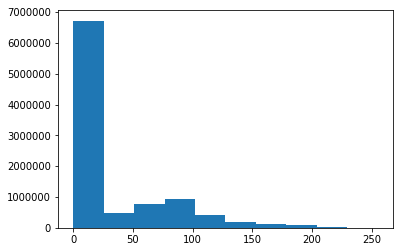

In [87]:
hist(x_train.ravel())